In [10]:
%store -r 

In [6]:
import os
import sys

sys.path.insert( 0, os.path.abspath("./utils") )


In [7]:
import time
from time import sleep
import json
from datetime import datetime
import numpy as np
import boto3
import pandas as pd

In [4]:
import pickle 
f = open('ranking_model.pkl', 'rb')
model = pickle.load(f)
model

Pipeline(memory=None,
         steps=[('svd',
                 TruncatedSVD(algorithm='randomized', n_components=400,
                              n_iter=5, random_state=None, tol=0.0)),
                ('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gbdt',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fractio

In [14]:
from bert import encode 
encoder = encode.Encoder(gpu=1)

In [11]:
from elastic_search import esquery as q
query = "shoes"
field = "product_title"


rjson = q.query(query, field, elastic_search_endpoint, master_user, master_user_password)
rjson

{'took': 36,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 9.366618,
  'hits': [{'_index': 'product',
    '_type': 'product',
    '_id': 'H-G5VnYBWQlvJU18C6GA',
    '_score': 9.366618,
    '_source': {'product_id': '0688161669',
     'product_category': 'Books',
     'product_title': 'Shoes, Shoes, Shoes (Mulberry Books)'}},
   {'_index': 'product',
    '_type': 'product',
    '_id': 'JOcLWXYBWQlvJU18N6fA',
    '_score': 9.158841,
    '_source': {'product_id': 'B00SUB9OF8',
     'product_category': 'Shoes',
     'product_title': 'Ballop Actos Aqua Shoes Skin Shoes Fitness Shoes Swim Shoes Yoga Shoes Water Shoes Triangle'}},
   {'_index': 'product',
    '_type': 'product',
    '_id': 'q1z-XHYB7ZcjQTgaI2ah',
    '_score': 8.742775,
    '_source': {'product_id': 'B00UV790DU',
     'product_category': 'Shoes',
     'product_title': '20to30 New Water Skin Shoes Aqua Shoes Fitn

In [21]:
queries = [] 
products = []
ids = [] 
to_transform = [] 
for i, r in enumerate(rjson['hits']['hits']): 
    ids.append(r['_source']['product_id'])
    queries.append(query)
    products.append(r['_source']['product_title'])
    to_transform.append([r['_source']['product_id'],r['_source']['product_title']])


{'_index': 'product', '_type': 'product', '_id': 'H-G5VnYBWQlvJU18C6GA', '_score': 9.366618, '_source': {'product_id': '0688161669', 'product_category': 'Books', 'product_title': 'Shoes, Shoes, Shoes (Mulberry Books)'}}
{'_index': 'product', '_type': 'product', '_id': 'JOcLWXYBWQlvJU18N6fA', '_score': 9.158841, '_source': {'product_id': 'B00SUB9OF8', 'product_category': 'Shoes', 'product_title': 'Ballop Actos Aqua Shoes Skin Shoes Fitness Shoes Swim Shoes Yoga Shoes Water Shoes Triangle'}}
{'_index': 'product', '_type': 'product', '_id': 'q1z-XHYB7ZcjQTgaI2ah', '_score': 8.742775, '_source': {'product_id': 'B00UV790DU', 'product_category': 'Shoes', 'product_title': '20to30 New Water Skin Shoes Aqua Shoes Fitness Shoes Yoga Shoes Pool Beach Swim Shoes'}}
{'_index': 'product', '_type': 'product', '_id': 'AdSNUnYBWQlvJU18cGtq', '_score': 8.730503, '_source': {'product_id': 'B00UV78Z1I', 'product_category': 'Shoes', 'product_title': '20to30 New Water Skin Shoes Aqua Shoes Fitness Shoes Yog

In [30]:
features = encoder.to_q_p_bert_embeddings(queries, products)
preds = model.predict(features)

In [23]:
for i, p in enumerate(preds): 
    to_transform[i].append(p)
    
reranked_result = sorted(to_transform, key=lambda x:x[2], reverse=True)    
reranked_result    

[['B00N4K858M',
  'Ballop Actos Aqua Shoes Skin Shoes Fitness Shoes Swim Shoes Yoga Shoes Wing Black (V2) XXL Size',
  3.5651769674130103],
 ['B00N4K83MU',
  'Ballop Actos Aqua Shoes Skin Shoes Fitness Shoes Swim Shoes Yoga Shoes Wing Black (V2) XL Size',
  3.5592241867836734],
 ['B00K44U5SE',
  'Summer Breathable Toning Shoes Platform Shoes Women Wedge Shoes',
  3.5083047363281046],
 ['B00K44U5M0',
  'Summer Breathable Toning Shoes Platform Shoes Women Wedge Shoes',
  3.5083047363281046],
 ['B00K44U68I',
  'Summer Breathable Toning Shoes Platform Shoes Women Wedge Shoes',
  3.5083047363281046],
 ['B00K44U5P2',
  'Summer Breathable Toning Shoes Platform Shoes Women Wedge Shoes',
  3.5083047363281046],
 ['B00K44U5O8',
  'Summer Breathable Toning Shoes Platform Shoes Women Wedge Shoes',
  3.5083047363281046],
 ['B00K44U5LG',
  'Summer Breathable Toning Shoes Platform Shoes Women Wedge Shoes',
  3.5083047363281046],
 ['B00K44U5L6',
  'Summer Breathable Toning Shoes Platform Shoes Women We

In [29]:
relevant_list = list(filter(lambda x: (x[2]>3.2), reranked_result))
relevant_ids = [x[0] for x in relevant_list]

In [31]:
from amz_review import data_proc 


rerank_user = 49240011
all_df = data_proc.get_user_history(rerank_user, original_data, items_df)
all_df.head()

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,index,product_id,product_category,product_title
0,B00IP4FGDO,49240011,5,1426464000,2032905,B00IP4FGDO,Health_&_Personal_Care,"Combat Source Kill Max Roach Killing Gel, 60 G..."
1,B000I62YR8,49240011,5,1380672000,5172588,B000I62YR8,Health_&_Personal_Care,"Metamucil Fiber Therapy for Regularity, Fiber ..."
2,B008JC82BA,49240011,4,1377043200,2954392,B008JC82BA,Wireless,IC ICLOVER 10pcs Stylus Touch Screen Pen iPhon...
3,B00BN4YBOI,49240011,5,1440547200,1467393,B00BN4YBOI,Digital_Video_Download,Lewis Black: Stark Raving Black
4,B001PNHWFC,49240011,5,1424044800,89761,B001PNHWFC,Kitchen,Ikea Cork Trivet


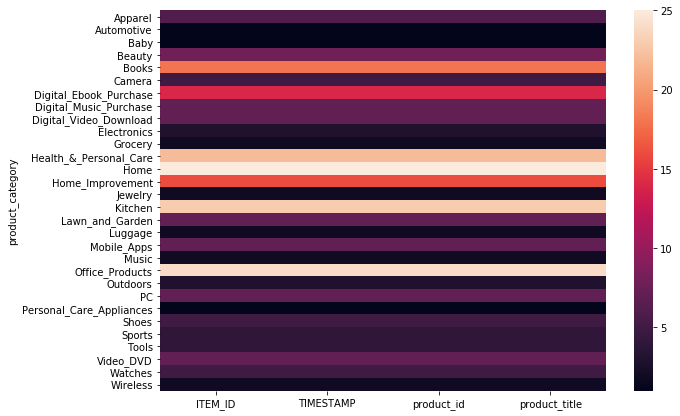

In [32]:
data_proc.plot_heat_map(all_df)

In [35]:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

get_recommendations_response_rerank = personalize_runtime.get_personalized_ranking(
    campaignArn = rerank_campaign_arn,
    userId = str(rerank_user),
    inputList = relevant_ids
)

# get_recommendations_response_rerank
    

In [39]:
relavance_list = []
for item in relevant_ids:
    product = data_proc.get_product_by_id(item, items_df)
    relavance_list.append(product)
relavance_df = pd.DataFrame(relavance_list, columns = ['Relevant Product title','Product Category'])

,Relevant Product title,Product Category
0,Ballop Actos Aqua Shoes Skin Shoes Fitness Sho...,Shoes
1,Ballop Actos Aqua Shoes Skin Shoes Fitness Sho...,Shoes
2,Summer Breathable Toning Shoes Platform Shoes ...,Shoes
3,Summer Breathable Toning Shoes Platform Shoes ...,Shoes
4,Summer Breathable Toning Shoes Platform Shoes ...,Shoes
...,...,...
62,"Benelaccio Boys Dress Up Shoes, Oxford Shoes, ...",Shoes
63,Character Shoes Dora Girls Casual Shoes,Shoes
64,Ariel Child Shoes Costume Shoes,Toys
65,Giggle Da Women Dance Shoes Ballet Shoes Soft ...,Shoes


In [48]:
original_list = []
for item in ids:
    product = data_proc.get_product_by_id(item, items_df)
    original_list.append(product)
original_df = pd.DataFrame(original_list, columns = ['Product title','Product Category'])

In [50]:
to_rerank_df = pd.concat([original_df[:relavance_df.shape[0]], relavance_df], axis=1)


In [51]:
data_proc.compare_personalized_result(to_rerank_df, get_recommendations_response_rerank, items_df)

,Product title,Product Category,Relevant Product title,Product Category,Original,Re-Ranked
0,"Shoes, Shoes, Shoes (Mulberry Books)",Books,Ballop Actos Aqua Shoes Skin Shoes Fitness Sho...,Shoes,SUIEK Unisex Baby Infant Swim Shoes Water Shoe...,Sports
1,Ballop Actos Aqua Shoes Skin Shoes Fitness Sho...,Shoes,Ballop Actos Aqua Shoes Skin Shoes Fitness Sho...,Shoes,"American Girl Shoes, 18 Inch Doll Shoes, WHITE...",Toys
2,20to30 New Water Skin Shoes Aqua Shoes Fitness...,Shoes,Summer Breathable Toning Shoes Platform Shoes ...,Shoes,SUIEK Unisex Baby Infant Swim Shoes Water Shoe...,Sports
3,20to30 New Water Skin Shoes Aqua Shoes Fitness...,Shoes,Summer Breathable Toning Shoes Platform Shoes ...,Shoes,Ballop Actos Aqua Shoes Skin Shoes Fitness Sho...,Shoes
4,Your Shoes My Shoes: We All Love Shoes!,Digital_Ebook_Purchase,Summer Breathable Toning Shoes Platform Shoes ...,Shoes,Ballop Actos Aqua Shoes Skin Shoes Fitness Sho...,Shoes
...,...,...,...,...,...,...
62,"Clothing, Shoes & Jewelry › Men › Shoes › Sandals",Shoes,"Benelaccio Boys Dress Up Shoes, Oxford Shoes, ...",Shoes,"Benelaccio Boys Dress Up Shoes, Oxford Shoes, ...",Shoes
63,Antia Shoes Women's Barbara Casual Shoes,Shoes,Character Shoes Dora Girls Casual Shoes,Shoes,Character Shoes Dora Girls Casual Shoes,Shoes
64,"Clothing, Shoes & Jewelry › Men › Shoes › Sandals",Shoes,Ariel Child Shoes Costume Shoes,Toys,Ariel Child Shoes Costume Shoes,Toys
65,Frisky Shoes Ladies Mesh Aqua Shoes,Shoes,Giggle Da Women Dance Shoes Ballet Shoes Soft ...,Shoes,Giggle Da Women Dance Shoes Ballet Shoes Soft ...,Shoes
